## TOPIC MODELLING AND SELF ORGANIZING MAPS

Here we are, we have gone through text preprocessing (stemmization, lemmatization, bigrams, etc...), perplexity, coherence, LDA and all that fun...for what?

Well, given that we know the document classes, we could use the topics to see if they are good predictors of the document class. However, I can anticipate that, in this case, other techniques will produce better results. Actually, my good friend Nadbor wrote a nice [post](http://nadbordrozd.github.io/blog/2017/08/12/looking-for-the-text-top-model/) benchmarking the many ways one can classify text, from Naive Bayes to LSTMs. 

However, for the excercise here, I will assume that we do not know the classes, and we simply have a series of news texts. From there, I am going to use Self Organizing maps to visualize the results, check that they make sense and build a "semantic fingerprint" of a user that has read certain articles.

I will do this in python...and R! I have not coded in R in ages, so I thought this would be a nice excercise to write a few line using my old good f**R**iend.

For the python version I will use the [`sompy` package](https://github.com/sevamoo/SOMPY) while for R I will use the [`kohonen` package](https://cran.r-project.org/web/packages/kohonen/kohonen.pdf).

As with LDA, it is not my intention to explain here how SOMs work. If the reader is interested, Chapter 14 of the book [Machine Learning: an algorithmic prespective](https://www.amazon.co.uk/Machine-Learning-Algorithmic-Perspective-Recognition/dp/1466583282/ref=sr_1_1?ie=UTF8&qid=1511018528&sr=8-1&keywords=machine+learning+algorithmic+perspective) provides a very nice explanation (this book is probably my favourite). 

At high level, what we are doing with a SOM is the following:

1. We build a map of N$\times$M units/neurons and we initialize the weights (at random or preferably we set them to increase in the direction of the 1st principal component of our data, i.e. we "help" the algorithm by indicating the direction of maximum variation of our data). If our observations have 10 features and our map is 30$\times$30, we will have 30$\times$30$\times$10 weights. 

2. For every observation we measure the distance to the units in the map and we assign the closet unit (best matching unit or bmu). We update the corresponding weights and also those of the neighbor units, using a neighbourhood function. This function tries to pull closer similar units and push away unist with very different weights. 

3. We repeat the process until we do not learn a better distribution, or new iterations lead to minimal improvement. At this point, similar units are located closer in the map, which implies that similar observations will be mapped into the same region of the SOM. 

So, to the code!

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cPickle as pickle
import sompy

# topic matrix, created with lemmatization, bigrams and 10 topics
topic_matrix = pickle.load(open("data_processed/document_topics_mtx.p", "rb"))

mapsize = [30,30]
som = sompy.SOMFactory.build(
    topic_matrix,
    mapsize,
    mask=None,
    mapshape='planar',
    lattice='rect',
    normalization='var',
    initialization='pca',
    neighborhood='gaussian',
    training='batch',
    name='sompy')
som.train(n_job=8, verbose='info')

 Training...
 pca_linear_initialization took: 0.044000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 2

 epoch: 1 ---> elapsed time:  0.138000, quantization error: 2.591554

 epoch: 2 ---> elapsed time:  0.137000, quantization error: 1.893296

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 2

 epoch: 1 ---> elapsed time:  0.238000, quantization error: 0.820654

 epoch: 2 ---> elapsed time:  0.137000, quantization error: 0.611441

 Final quantization error: 0.611441
 train took: 0.706000 seconds


In the first place, one might wonder why have I used a 30 by 30 neurons/units map? To answer this question let's do the following

In [2]:
mapsize = [50,50]
som50 = sompy.SOMFactory.build(
    topic_matrix,
    mapsize,
    mask=None,
    mapshape='planar',
    lattice='rect',
    normalization='var',
    initialization='pca',
    neighborhood='gaussian',
    training='batch',
    name='sompy')
som50.train(n_job=8, verbose='info')

# The method find_k_nodes will find the nearest neightbors given an input. 
# The nearest neightbor will then be the location of that observation in 
# the map.
node_hits = []
for i in range(len(topic_matrix)):
    data = topic_matrix[i].reshape(1,-1)
    loc = som50.find_k_nodes(data)[1][0][0]
    node_hits.append(loc)

from collections import Counter
node_counts = Counter(node_hits)

print(node_counts)

 Training...
 pca_linear_initialization took: 0.059000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 4

 epoch: 1 ---> elapsed time:  0.475000, quantization error: 2.591419

 epoch: 2 ---> elapsed time:  0.469000, quantization error: 1.914757

 epoch: 3 ---> elapsed time:  0.481000, quantization error: 1.041139

 epoch: 4 ---> elapsed time:  0.499000, quantization error: 0.779601

 Finetune training...
 radius_ini: 1.750000 , radius_final: 1.000000, trainlen: 6

 epoch: 1 ---> elapsed time:  0.454000, quantization error: 0.582613

 epoch: 2 ---> elapsed time:  0.480000, quantization error: 0.525409

 epoch: 3 ---> elapsed time:  0.487000, quantization error: 0.491018

 epoch: 4 ---> elapsed time:  0.493000, quantization error: 0.462694

 epoch: 5 ---> elapsed time:  0.495000, quantization error: 0.437059

 epoch: 6 ---> elapsed time:  0.475000, quantization error: 0.411652

 Final quantization error: 0.411652
 train took: 4.901000 seconds


Counter({1800: 348, 0: 298, 16: 172, 1449: 162, 2467: 134, 299: 90, 50: 86, 51: 80, 780: 78, 2450: 76, 1801: 66, 67: 64, 101: 63, 1650: 63, 400: 62, 117: 59, 550: 58, 300: 57, 1315: 56, 1500: 54, 1851: 54, 100: 51, 1053: 50, 150: 46, 1628: 46, 3: 45, 152: 43, 654: 43, 17: 42, 233: 42, 1700: 42, 1100: 41, 1852: 41, 2418: 41, 1452: 40, 5: 38, 1400: 38, 1902: 38, 1398: 37, 1448: 37, 2: 35, 702: 35, 1302: 35, 2452: 35, 4: 34, 38: 34, 151: 34, 2499: 34, 849: 33, 949: 33, 1086: 33, 22: 32, 30: 32, 1299: 32, 1602: 32, 39: 31, 1049: 31, 1249: 31, 45: 30, 1347: 30, 1804: 30, 546: 29, 1149: 29, 2149: 29, 2457: 29, 6: 28, 10: 28, 267: 28, 564: 28, 1397: 28, 1600: 28, 1805: 28, 2347: 28, 2351: 28, 24: 27, 25: 27, 246: 27, 1099: 27, 1654: 27, 2200: 27, 8: 26, 9: 26, 49: 26, 250: 26, 599: 26, 999: 26, 1199: 26, 2453: 26, 2472: 26, 7: 25, 27: 25, 28: 25, 353: 25, 354: 25, 450: 25, 500: 25, 749: 25, 2458: 25, 2495: 25, 20: 24, 169: 24, 200: 24, 800: 24, 950: 24, 1157: 24, 1350: 24, 1803: 24, 1806: 24,

There are a few comments here. First we see that the "edge-nodes" receive a lot of observations. This is a well known boundary effect in SOMs. Such effect can be mittigated by using circular kohonen layers (read [here](https://www.computer.org/csdl/proceedings/hicss/1997/7734/05/7734050521.pdf)), but for the time being, we will live with this. 

Second, if we count the number of nodes with at least one observation:

In [3]:
len(node_counts)

2398

we see that 102 nodes receive no observation, are empty. In other words, we do not need a 50x50 map. The same applies to a 40x40 while only a handful of units are empty when using a 30x30 map.

Now let's have a look to the maps per topic:

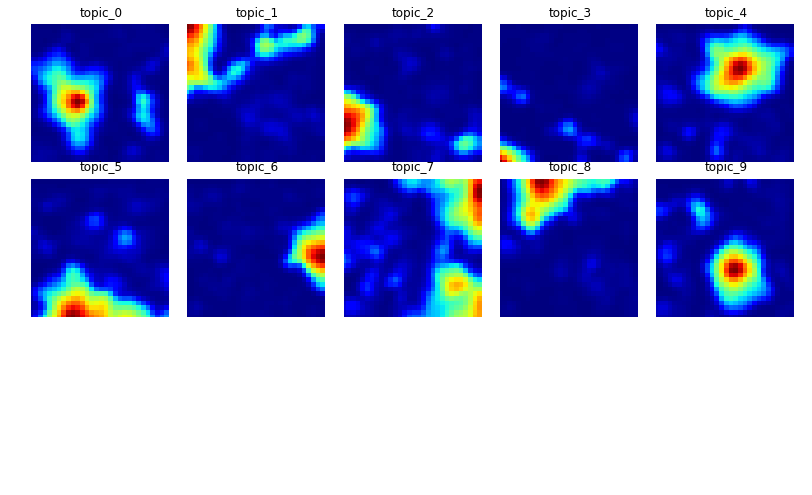

In [4]:
som.component_names = ["_".join([t,str(i)]) for i,t in enumerate(['topic']*10)]
v = sompy.mapview.View2DPacked(30, 30, '',text_size=10)
v.show(som, what='codebook', which_dim='all', cmap='jet', col_sz=5)

Pretty plot, and also interesting. We see that topics are quite complementary, filling different regions of the map. This already indicates that the codebook matrix (i.e. the weights per unit) will cluster well. Let's have a look to some topics

In [9]:
import cPickle as pickle
topic_words = pickle.load(open("data_processed/topic_words_final_model.p", "rb"))
topic_words[2]

[2,
 [(u'god', 0.0135894452495191),
  (u'people', 0.0080426919663883507),
  (u'think', 0.0072901074275660569),
  (u'know', 0.0069321409464733778),
  (u'say', 0.0061304522725546366),
  (u'believe', 0.005991047850126276),
  (u'jesus', 0.0056023730210805756),
  (u'mean', 0.0054946813096645184),
  (u'article', 0.0051945304137257257),
  (u'like', 0.004437144274944009)]]

In [11]:
topic_words[9]

[9,
 [(u'space', 0.0080672210014638476),
  (u'nasa', 0.0052129232850348867),
  (u'information', 0.0049126024438018185),
  (u'new', 0.0048726118165552191),
  (u'research', 0.0040059348710702655),
  (u'program', 0.0039375986228288827),
  (u'include', 0.0034177765777620448),
  (u'university', 0.0031683859225309472),
  (u'group', 0.0031176285632192879),
  (u'national', 0.0030656024826118365)]]

so, topic_2 is related to religion and topic_9 looks like science

As I said before, the plot suggests that the `codebook.matrix` (i.e the node weights) will cluster well, so let's have a look

/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


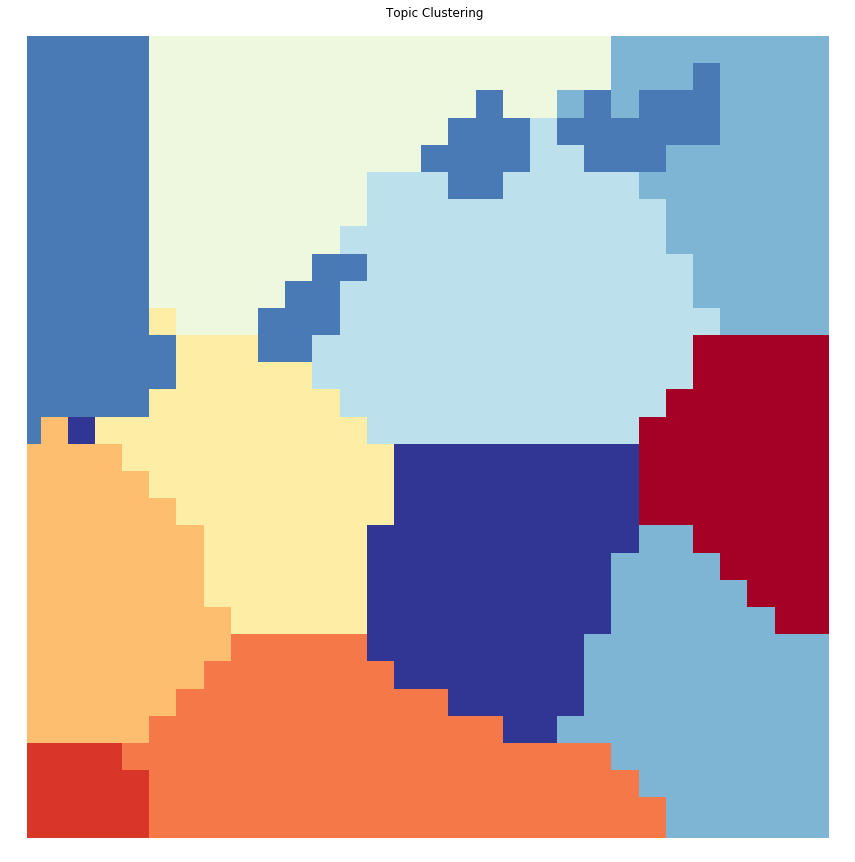

In [12]:
v = sompy.mapview.View2DPacked(10, 10, 'Topic Clustering',text_size=10)
cl = som.cluster(n_clusters=10, random_state=0)
# I am using the default plotting methods. I am sure this can be made prettier...
v.show(som, what='cluster')

By the way, if you build the package and run the command 

```
cl = som.cluster(n_clusters=10, random_state=0)
```
it will through an error since the `random_state` parameter is not defined. This is because in the original version, the cluster method looks like: 

```    
def cluster(self, n_clusters=8):
    import sklearn.cluster as clust
    cl_labels = clust.KMeans(n_clusters=n_clusters).fit_predict(
        self._normalizer.denormalize_by(self.data_raw,
                                        self.codebook.matrix))
    self.cluster_labels = cl_labels
    return cl_labels
```

you simply need to replace that with
```    
def cluster(self, n_clusters=8, random_state=None):
    import sklearn.cluster as clust
    cl_labels = clust.KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(
        self._normalizer.denormalize_by(self.data_raw,
                                        self.codebook.matrix))
    self.cluster_labels = cl_labels
    return cl_labels
```

and done. Then build it `python setup.py install`.

Let's have a look with cluster labels.

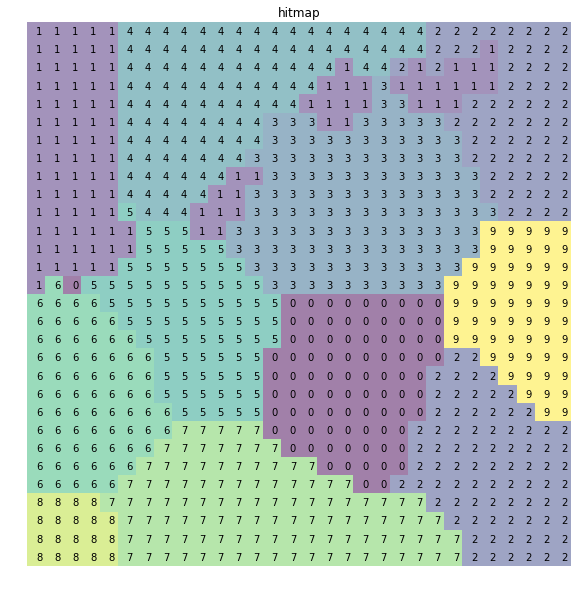

array([[  0,   0,   0],
       [  0,   1,   1],
       [  0,   2,   2],
       ..., 
       [ 29,  27, 897],
       [ 29,  28, 898],
       [ 29,  29, 899]])

In [13]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

One can see that cluster_0 contains "space-science" related documents. 

What else can we do with it? 

well, I was once an astronomer, so, let's say that out of all the documents here, I would be more interested in those related to space and science. Let's build my "semantic fingerprint"

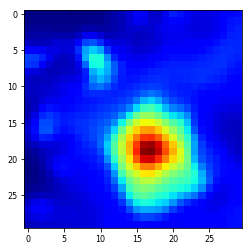

In [15]:
# Get the coorfinates in the map
import random
coords = som.bmu_ind_to_xy(np.arange(som.codebook.nnodes))

# let's make use of the fact that we know the document classes and say 
# that I have read 3 space science related documents at random 
document_class = pd.read_csv("data_processed/document_class.txt")
space_sci = document_class.loc[document_class.document_class == 'sci.space'].index.tolist()
rand_doc_idx = random.sample(space_sci, 3)

# Extract the corresponding documents 
space_sci_docs = topic_matrix[rand_doc_idx, :]

# Build the user profile by averaging. Note that here one can get as clever
# as you want. You could calculate a weighted average with weights that account
# for the the number of words in the document and the time spent reading, or any
# other proxy of "interest"
user_profile = np.mean(space_sci_docs, axis=0).reshape(1, -1)
weights = som.codebook.matrix.T
activations = user_profile.dot(weights)[0]

act_matrix = np.zeros([30,30])
for i,j,idx in coords:
    act_matrix[i,j] = activations[idx]

import matplotlib.pyplot as plt
plt.imshow(act_matrix, cmap='jet', interpolation='nearest')
plt.show()

And as expected, my fingerprint is almost identical to that of topic_6, which dominates to space-science related documents